,0,lag2,diff
0,54.0,NaN,NaN
1,54.7,NaN,NaN
2,55.7,54.0,1.7
3,55.5,54.7,0.8
4,55.7,55.7,0.0
...,...,...,...
431970,55.4,54.8,0.6
431971,56.0,55.3,0.7
431972,55.8,55.4,0.4
431973,57.0,56.0,1.0


,0,lag2,diff
0,55.7,54.0,1.7
1,55.5,54.7,0.8
2,55.7,55.7,0.0
3,55.6,55.5,0.1
4,55.8,55.7,0.1
...,...,...,...
431968,55.4,54.8,0.6
431969,56.0,55.3,0.7
431970,55.8,55.4,0.4
431971,57.0,56.0,1.0


0         1.7
1         0.8
2         0.0
3         0.1
4         0.1
         ... 
431968    0.6
431969    0.7
431970    0.4
431971    1.0
431972    1.3
Name: diff, Length: 431973, dtype: float64

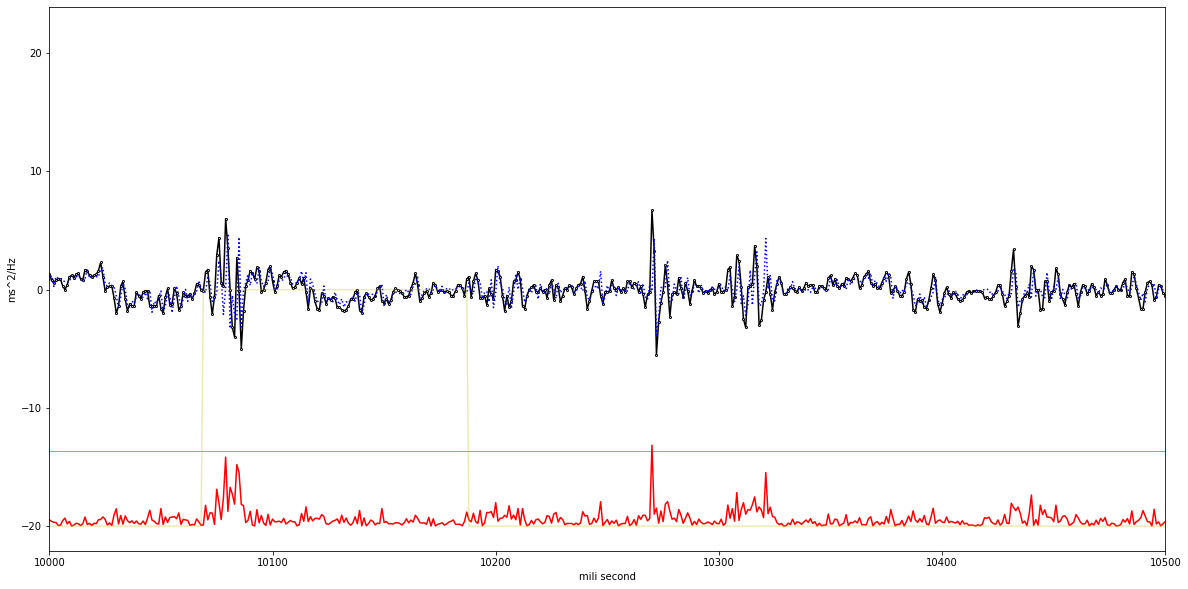

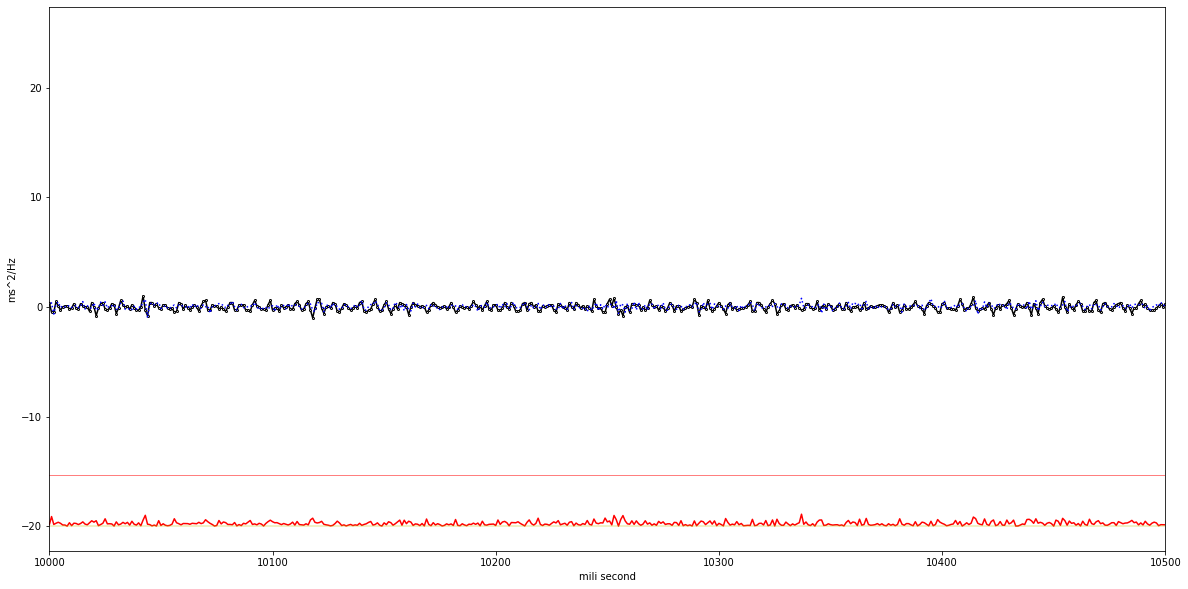

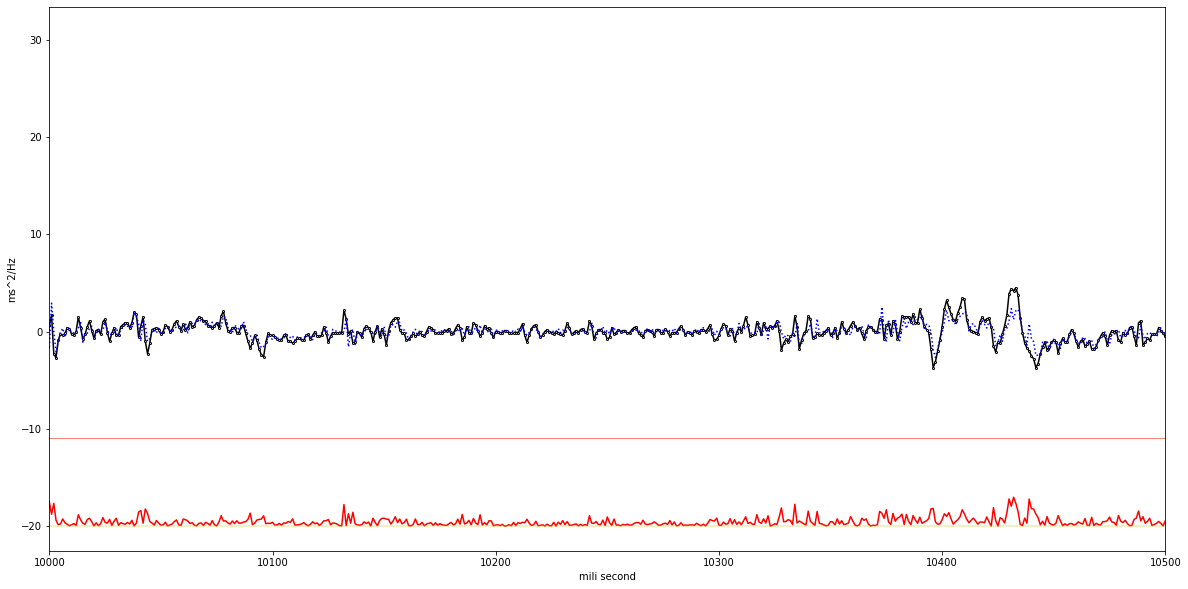

CV Score:
  Precision Score = 0.210648
  Recall Score = 0.019470
  F1 Score = 0.035558
  Accuracy Score = 0.988246


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import KFold

def make_data(x):
    window=10
    for i in range(1, window):
        column=f'lag{i}'
        x[column]=x[0].shift(i)
    
    return x

# 差分値をとる
def make_diff(x, y):
    point=2
    column=f'lag{point}'
    x[column]=x.shift(point)
    x['diff']=x[0]-x[column]
    display(x)
    x=x.dropna().reset_index(drop=True)
    display(x)
    display(x['diff'])
    return x['diff'], y[point:]

if __name__ == '__main__':
    df = pd.read_csv( os.path.join('dataset', 'learning_data_431975.csv'), header=None  )
    x = df[ df.columns[ :-1 ] ]
    x=x[(x.shape[1]-1)/2]
    
    # 差分をとってみる
    x=pd.DataFrame(x)
    x.columns=range(len(x.columns))
    y=  df[ df.columns[ -1 ] ]
    x, y=make_diff(x, y)
    kf = KFold( n_splits=3, shuffle=False )
    pr=[]
    re=[]
    f1 = []
    ac = []
    y_Leq=[]
    pred_Leq=[]
    no_Leq=[]
    n = []

    for train_index, test_index in kf.split( x ):
        x_train, x_test = x.iloc[train_index].values, x.iloc[test_index].values
        y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

        # 学習データには正常データだけを使う
        x_train=pd.DataFrame(x_train)
        y_train=pd.DataFrame(y_train)

        x_train=make_data(x_train)
        x_train['label']=y_train
        x_train = x_train.dropna().reset_index(drop=True)
        x_train=x_train[x_train['label']==0]

        X_train = x_train[x_train.columns[1:-1]].values
        Y_train =x_train[0].values

        x_test_df=pd.DataFrame(x_test)

        x_test_df=make_data(x_test_df)
        x_test_df = x_test_df.dropna().reset_index(drop=True)

        X_test = x_test_df[x_test_df.columns[1:]].values
        Y_test = x_test_df[0].values

        r_forest = RandomForestRegressor(
                    n_estimators=20,
                    criterion='mse',
                    random_state=1,
                    n_jobs=-1
        )

        r_forest.fit(X_train, Y_train)
        y_test_pred=r_forest.predict(X_test)

        # 生データをプロット
        ax =  x_test_df[0].plot(figsize=(20,10), grid=False, color=['k'], marker ='o', markersize=2, markerfacecolor='w',
                                xlim=[10000, 10500])
        # 回帰データをプロット
        ax.plot(y_test_pred,linestyle='dotted',color='b')
        # 異常度をプロット
        ax.plot(np.abs(y_test_pred-Y_test)-20,linestyle='solid',color='r',alpha=1)
        
        ax.set_xlabel('mili second')
        ax.set_ylabel('ms^2/Hz')

        abnorm =np.abs(y_test_pred-Y_test)-20
        abnorm=np.array(abnorm)
        th_data=abnorm.copy()
        th_data.sort(axis=0)
        num=int(0.001*len(th_data))
        th=th_data[::-1][num]

        # 異常度の閾値のライン
        plt.plot([0,150000], [th,th] , color='red', linestyle='-', linewidth=0.5)

        # 異常ラベルをプロット
        y_test=y_test[X_test.shape[1]:]
        ax.plot(y_test*20-20,linestyle='solid',color='y',alpha=0.3)
        plt.show()

        z=np.where(abnorm>=th, 1, 0)
        pr.append( precision_score( y_test, z ) )
        re.append( recall_score( y_test, z) )
        f1.append( f1_score( y_test, z ) )
        ac.append( accuracy_score( y_test, z ) )
        n.append( len( x_test ) / len( x ) )

    print( 'CV Score:' )
    print( '  Precision Score = %f'%( np.average( pr, weights=n ) ) )
    print( '  Recall Score = %f'%( np.average( re, weights=n ) ) )
    print( '  F1 Score = %f'%( np.average( f1, weights=n ) ) )
    print( '  Accuracy Score = %f'%( np.average( ac, weights=n ) ) )

